In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

def evaluate_detections(results,
                        threshold: float,
                        conf: float,
                        labels_dir: str = "../../parse_data_add_val_data/yolo_dataset/labels/val",
                        voxel_csv_path: str = "/mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/input/byu-locating-bacterial-flagellar-motors-2025/train_labels.csv",):

    # 1) 前処理: VOXEL データ読み込み & カラム定義
    column = ["obj_name", "x_max", "y_max", "x_min", "y_min"]
    voxel_df = pd.read_csv(voxel_csv_path)

    TP = 0
    FP = 0
    FN = 0
    dists = []

    for r in results:
        # 2) 予測の有無判定
        no_pred = (r.boxes.conf.cpu().item() < conf)

        # 3) アノテーション読み込み
        fname = os.path.basename(r.path)
        base, _ = os.path.splitext(fname)
        txt_fname = base + ".txt"
        anno_path = os.path.join(labels_dir, txt_fname)

        df = pd.read_csv(
            anno_path,
            sep=r"\s+",
            engine="python",
            header=None,
            names=column
        )

        # 4) GT ボックス有無ごとの分岐
        if df.empty and no_pred:
            continue
        elif df.empty:
            FP += 1
            # 背景中にモーターがない画像
            continue
        elif no_pred:
            # モーターあり画像なのに予測なし
            FN += 1
            continue

        # 5) 真の中心座標計算
        true_center = [
            (df["x_max"].item() + df["x_min"].item()) / 2,
            (df["y_max"].item() + df["y_min"].item()) / 2
        ]

        # 6) 元画像サイズに合わせてスケール補正
        stem = Path(fname).stem
        prefix = "_".join(stem.split("_")[:2])  # tomo_00e463 の部分
        # Z軸方向
        if r.orig_shape[0] >= 960:
            scale_z = (
                voxel_df.loc[voxel_df["tomo_id"]==prefix, "Array shape (axis 2)"]
                       .mean() / 960
            )
            true_center[0] *= scale_z
        # Y軸方向
        if r.orig_shape[1] >= 960:
            scale_y = (
                voxel_df.loc[voxel_df["tomo_id"]==prefix, "Array shape (axis 1)"]
                       .mean() / 960
            )
            true_center[1] *= scale_y

        # 7) Voxel spacing
        vs = voxel_df.loc[voxel_df["tomo_id"]==prefix, "Voxel spacing"].mean()

        # 8) 予測中心座標
        pred = r.boxes.xyxy.cpu().numpy()  # shape (M,4)
        pred_center = [(pred[:,0].item()+pred[:,2].item())/2, (pred[:,1].item()+pred[:,3].item())/2 ]

        diff = ((true_center[0]-pred_center[0])**2 + (true_center[1]-pred_center[1])**2)**0.5
        phys_dists = diff * vs               

        if phys_dists <= threshold:
            TP += 1
        else:
            FP += 1

    return TP, FP, FN, dists

# --- 使い方例 ---
# TP, FP, FN, dists = evaluate_detections(results, threshold=9000, conf=0.5)


In [35]:
results[0].boxes.conf

TypeError: 'generator' object is not subscriptable

In [29]:
TP, FP, FN, dists = evaluate_detections(results, threshold=9000, conf=0.5)


In [31]:
FP

0

In [12]:
from ultralytics import YOLO
import matplotlib.pyplot as plt



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1497 /mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/survey/survey_5/../../parse_data_add_val_data/yolo_dataset/images/val/tomo_00e463_z0218_y0379_x0144.jpg: 928x960 1 motor, 25.9ms
image 2/1497 /mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/survey/survey_5/../../parse_data_add_val_data/yolo_dataset/images/val/tomo_00e463_z0219_y0379_x0144.jpg: 928x960 1 motor, 25.1ms
image 3/1497 /mnt/c/Users/tkdgk/BYU---Locating-Bac

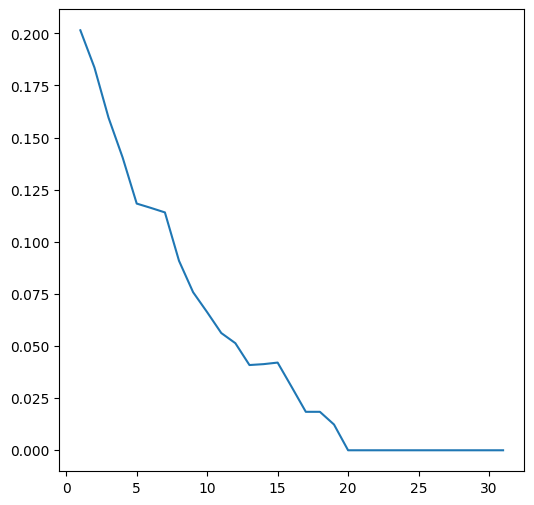



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1497 /mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/survey/survey_5/../../parse_data_add_val_data/yolo_dataset/images/val/tomo_00e463_z0218_y0379_x0144.jpg: 928x960 1 motor, 26.2ms
image 2/1497 /mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/survey/survey_5/../../parse_data_add_val_data/yolo_dataset/images/val/tomo_00e463_z0219_y0379_x0144.jpg: 928x960 1 motor, 25.3ms
image 3/1497 /mnt/c/Users/tkdgk/BYU---Locating-Bac

In [ ]:
weight_path = "/mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/yolo/outputs/2025-05-07/19-51-56/42/yolo11l_train/weights"
total_epoch = 70
yaml_path = "/mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/parse_data_add_val_data/yolo_dataset/dataset.yaml"
data_path = "../../parse_data_add_val_data/yolo_dataset/images/val"
for i in range(total_epoch):
    # os.makedirs(f"result_{i}", exist_ok=True)
    # os.chdir(f"result_{i}")
    weight = os.path.join(weight_path ,f"epoch{i}.pt")
    model = YOLO(weight)

    results = model.predict(
    source=data_path,  # 画像フォルダでも単一画像でもOK
    conf=0.0,
    max_det=1,
    save=False,               # ファイル出力はせず戻り値のみ
    save_txt=False,
    #stream=True
    )
    F2 = []
    for conf in np.linspace(0.3, 0.6, 31):
        TP, FP, FN, _ = evaluate_detections(results, threshold=9000, conf=conf, 
                                                labels_dir="../../parse_data_add_val_data/yolo_dataset/labels/val")
        f2 = 5 * TP/(5*TP + 4*FP + FN)
        F2.append(f2)
    
    plot = np.linspace(1, 31, 31)
    plt.figure(figsize=(6,6))
    plt.plot(plot, F2)
    plt.show()
    plt.savefig(f"result_of_epoch_{i}.png")



In [26]:
column = ["obj_name", "x_max", "y_max", "x_min", "y_min"]
df = pd.read_csv("/mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/parse_data_add_val_data/yolo_dataset/labels/val/tomo_fe85f6_z0023_y-001_x-001.txt",
 sep=r"\s+",
 engine="python",
 header=None,
 names=column)

In [27]:
df

Empty DataFrame
Columns: [obj_name, x_max, y_max, x_min, y_min]
Index: []

In [28]:
df.empty

True